# Leafotev 🍃

An application to detect plants' disease via their 🍃

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models 
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/specific-dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)
class_names = dataset.class_names

Found 2152 files belonging to 3 classes.


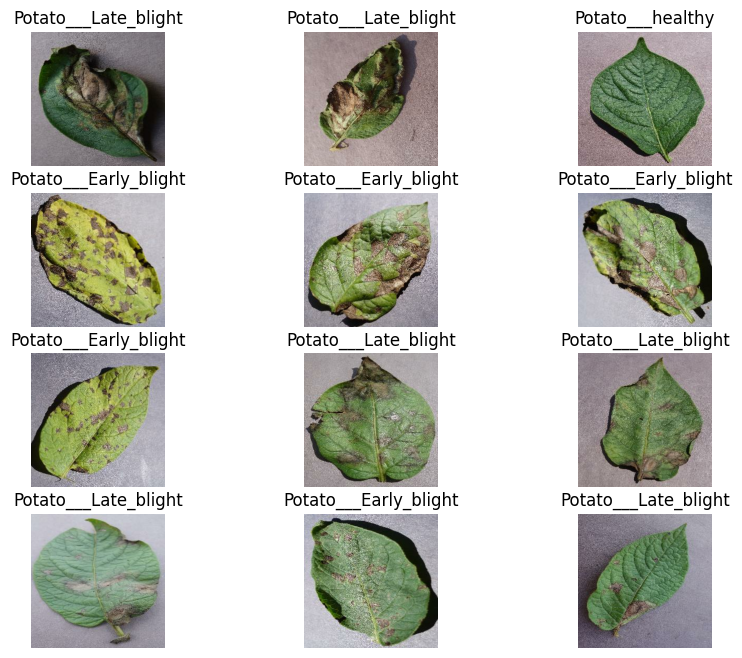

In [6]:
plt.figure(figsize=(10, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def split_dataset(dataset, train_split=0.8, test_split=0.1, validation_split=0.1, shuffle_size=1000):
    dataset = dataset.shuffle(shuffle_size)

    # define sizes of the datasets based on split give via args
    total_dataset_size = len(dataset)
    train_size = int(total_dataset_size * train_split)
    test_size = int(total_dataset_size * test_split)
    validation_size = int(total_dataset_size * validation_split)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)

    return train_dataset, test_dataset, validation_dataset

In [8]:
train_dataset, test_dataset, validation_dataset = split_dataset(dataset)

In [9]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
rescale_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [13]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = models.Sequential([
    rescale_resize,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 201s 3s/step - loss: 0.8852 - accuracy: 0.5116 - val_loss: 0.7080 - val_accuracy: 0.6875
Epoch 2/50
54/54 [==============================] - 132s 2s/step - loss: 0.6087 - accuracy: 0.7483 - val_loss: 0.5632 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 140s 3s/step - loss: 0.4358 - accuracy: 0.8339 - val_loss: 0.3018 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 128s 2s/step - loss: 0.2938 - accuracy: 0.8779 - val_loss: 0.3156 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 127s 2s/step - loss: 0.2955 - accuracy: 0.8981 - val_loss: 0.1952 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 129s 2s/step - loss: 0.1905 - accuracy: 0.9311 - val_loss: 0.2419 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 127s 2s/step - loss: 0.1464 - accuracy: 0.9514 - val_loss: 0.2466 - val_accuracy: 0.8750
Epoch 8/50


In [23]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_dataset)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 12s 641ms/step - loss: 0.0952 - accuracy: 0.9609
Test Accuracy: 96.09%


In [25]:
import os
model.save(f"trained_model")

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets
